<h1><center>Assignment2 - ML <br>
            Narendra Parigi <br>
            12089265 <br>
</center></h1>

In [1]:
import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectFromModel

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


%matplotlib inline
warnings.filterwarnings('ignore')
#pd.options.mode.chained_assignment = None

### 1.Data Preparation

#### Loading the data, verifying for nans

In [2]:
features = pd.read_csv('afsis_mbabd_nan.csv', index_col='SSN')
targets = pd.read_csv('targets.csv', index_col='SSN')
print('The size of features dataframe: {}'.format(features.shape[0]))
print('The size of targets dataframe: {}'.format(targets.shape[0]))

The size of features dataframe: 7346
The size of targets dataframe: 1907


In [3]:
features_columns = features.columns
targets_columns = targets.columns

In [4]:
print('The columns with missing values in features dataframe: {}'
      .format(list(features.columns[features.isna().any()])))
print('The colimns with missing values in targets dataframe: {}'
      .format(list(targets.columns[targets.isna().any()])))

The columns with missing values in features dataframe: ['004412.438']
The colimns with missing values in targets dataframe: ['M3 Na', 'M3 S']


#### Removing the rows with missing values from targets dataframe

In [5]:
targets_wona = targets.dropna(axis=0)
print('The size of targets dataframe after removing rows with missing values: {}'.format(targets_wona.shape[0]))

The size of targets dataframe after removing rows with missing values: 1899


#### Joining the dataframes features with targets_wona

In [6]:
features_targets_wona = features.merge(targets_wona, left_index=True, right_index=True, how='left')
print('The size of features_targets_wona dataframe: {}'.format(features_targets_wona.shape[0]))
print('The columns with missing values in combined dataframe: {}'
      .format(list(features_targets_wona.columns[features_targets_wona.isna().any()])))

The size of features_targets_wona dataframe: 7346
The columns with missing values in combined dataframe: ['004412.438', 'Public', 'EC', 'ExAc', 'ExBas', 'M3 Al', 'M3 B', 'M3 Ca', 'M3 Cu', 'M3 Fe', 'M3 K', 'M3 Mg', 'M3 Mn', 'M3 Na', 'M3 P', 'M3 S', 'M3 Zn', 'PH', 'PSI']


There are alot of columns missing the data after join, let us understand what is heppening here!
Lets find all the SSNs with missing values.

In [7]:
features_targets_wona[features_targets_wona.Public.isna()].index.unique()

Index(['icr049257', 'icr049258', 'icr068499', 'icr070276', 'icr070288',
       'icr072385', 'icr072896', 'icr072897'],
      dtype='object', name='SSN')

In [8]:
targets[(targets.index == 'icr049257')
        |(targets.index == 'icr049258')
        |(targets.index == 'icr068499')
        |(targets.index == 'icr070276')
        |(targets.index == 'icr070288')
        |(targets.index == 'icr072385')
        |(targets.index == 'icr072896')
        |(targets.index == 'icr072897')]

,Public,EC,ExAc,ExBas,M3 Al,M3 B,M3 Ca,M3 Cu,M3 Fe,M3 K,M3 Mg,M3 Mn,M3 Na,M3 P,M3 S,M3 Zn,PH,PSI
SSN,,,,,,,,,,,,,,,,,,
icr049257,True,0.041,0.180,2.773280,142.0,0.220,445.0,0.260,31.0,30.6,53.7,16.30,6.03,9.58,NaN,1.28,6.74,-0.24
icr049258,True,0.027,0.230,1.367158,106.0,0.001,197.0,0.001,36.7,23.5,27.5,3.07,21.80,2.76,NaN,0.45,6.38,-2.74
icr068499,True,0.119,0.250,5.667063,428.0,0.001,862.0,0.440,204.0,159.0,115.0,24.60,NaN,14.80,4.67,1.40,5.97,14.90
icr070276,True,0.011,0.096,1.127672,522.0,0.001,156.0,0.600,183.0,12.5,38.2,132.00,NaN,1.96,3.87,0.80,6.00,38.00
icr070288,True,0.102,0.140,5.308735,311.0,0.001,861.0,0.680,91.7,46.7,107.0,37.50,NaN,63.10,5.04,3.29,6.24,18.20
icr072385,True,0.023,1.740,0.541686,912.0,0.001,76.4,0.001,131.0,29.8,10.1,23.10,NaN,8.05,9.19,0.80,5.26,66.70
icr072896,True,0.020,0.190,1.699832,305.0,0.001,261.0,0.250,38.5,24.8,40.1,32.70,NaN,3.74,1.67,0.54,6.14,24.00
icr072897,True,0.010,0.190,1.268019,361.0,0.001,157.0,0.410,44.5,38.6,46.5,22.60,NaN,2.08,1.67,0.68,5.75,31.60


This means not every observation in features dataframe has a matching entry in targets(after removing the rows with missing values) dataframe. so, I am gonna use targets AS IS without dropping the rows with the missing values for joining so, each entry in features dataframe will have matching entry in targets. For the next steps, will consider the target which is always filled next to the features set.

In [9]:
features_targets = features.merge(targets, left_index=True, right_index=True, how='left')
print('The columns with missing values in combined dataframe: {}'
      .format(list(features_targets.columns[features_targets.isna().any()])))

The columns with missing values in combined dataframe: ['004412.438', 'M3 Na', 'M3 S']


In [10]:
features_targets[features_targets.Public.isna()].index.unique()

Index([], dtype='object', name='SSN')

#### Features data imputation

Generally, we dont impute target columns but impute only feature columns. 

The column '004412.438' has missing values in features dataset. we will use different approaches to impute the values for this column and select the best possible imputation method.

As part of machine learning/data science, we always train our model with past data and evaluate model on future dataset. so, it is not a good practice to impute missing values considering all the dataset. Therefore, we already split the data to train and test split and impute the train and test dataset seperately.

Also, decided to use 'M3 Al' (aluminium) column as target variabl as it is filled for every row in dataframe (targets).

In [11]:
X = features_targets[features_columns]
y = features_targets['M3 Al']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
X_train = X_train.copy()
X_test = X_test.copy()

##### Simple Imputer
    
Imputation transformer for completing missing values

In [13]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
X_train["004412.438_imp"] = imp.fit_transform(X_train[["004412.438"]]).ravel()
print('The following are few examples to compare the imputed feature values with original feature values')
X_train[['004412.438','004412.438_imp']][X_train['004412.438'].isna()].head(3)

The following are few examples to compare the imputed feature values with original feature values


,004412.438,004412.438_imp
SSN,,
icr005986,NaN,0.319363
icr037491,NaN,0.319363
icr073148,NaN,0.319363


Lets calculate the mean of a feature manually and to compare with imputed value.

In [14]:
print('The mean value of column "004412.438": {:.6f}'.format(X_train['004412.438'].mean()))

The mean value of column "004412.438": 0.319363


The main intention of mean imputation is to preserve the mean of the observed data but 
- mean imputation does not take into account a fact that the correlation may exist between column with missing values and other features.
- Moreover, mean imputation reduces the variance of the dataset.

In [15]:
def plot_imputation_data(X_imp, col_orig, col_imp, col_y, title):
    """ helper function to plot the imputed data """
    imputed_mask = np.any(np.isnan(X_imp), axis=1)
    plt.figure(figsize=(15,8))
    plt.scatter(X_imp[col_imp][~imputed_mask], X_imp[col_y][~imputed_mask],
                c=plt.cm.tab10(X_imp[col_imp][~imputed_mask]), marker="o")
    plt.scatter(X_imp[col_imp][imputed_mask], X_imp[col_y][imputed_mask], 
            c=plt.cm.tab10(X_imp[col_imp][imputed_mask]), marker="s")
    square = plt.Line2D((0,), (0,), linestyle='', marker="s", markerfacecolor="w", markeredgecolor="k", 
                    label='Imputed data')
    circle = plt.Line2D((0,), (0,), linestyle='', marker="o", markerfacecolor="w", markeredgecolor="k", 
                    label='Real data')
    plt.legend(handles=[square, circle], numpoints=1, loc="best")
    plt.title(title)

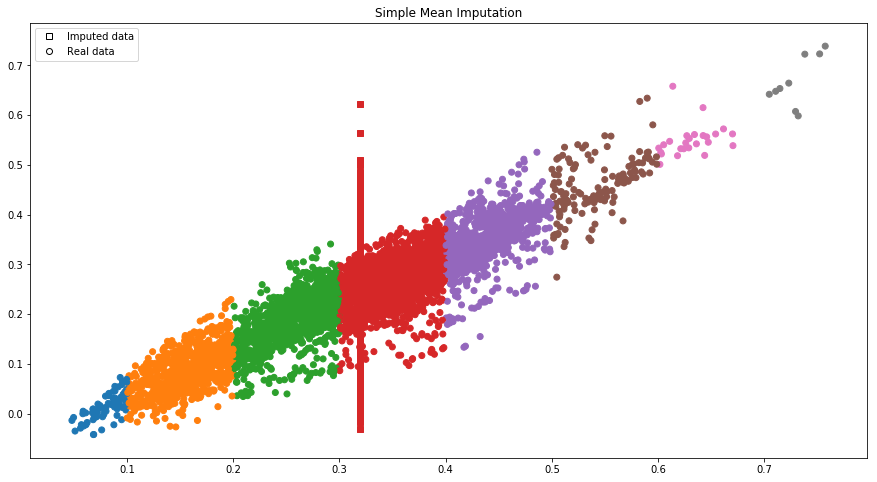

In [16]:
X_imp = X_train[['004412.438','004412.438_imp','007498.059']]
plot_imputation_data(X_imp,'004412.438','004412.438_imp','007498.059', 'Simple Mean Imputation')

In [17]:
print ('The variance of the column "004412.438" before imputation is : {0:.3f} and after imputation is : {1:.3f}'
       .format(X_train['004412.438'].var(),X_train['004412.438_imp'].var()))

The variance of the column "004412.438" before imputation is : 0.011 and after imputation is : 0.010


<b> <i> The mean imputation creates the straight line (correlation between '004412.438_imp' and '007498.059') and reduced the variance of imputed features. </i> </b>

###### KNN Imputer: 
Imputation for completing missing values using k-Nearest Neighbors. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. The assumption behind using the KNN for missing values is that a point value can be approximated using the nearest neighbors (other feature variables).

In [18]:
feature_004412_438_missing = np.isnan(X_train["004412.438"])
train_cols = [col for col in features_columns if col !='004412.438']
knn_feature_004412_438 = KNeighborsRegressor().fit(X_train[train_cols][~feature_004412_438_missing],
                                         X_train['004412.438'][~feature_004412_438_missing])
knn_predictions = knn_feature_004412_438.predict(X_train[train_cols][feature_004412_438_missing])
X_train.loc[feature_004412_438_missing, '004412.438_knn_imp']  = knn_predictions.ravel()
X_train.loc[~feature_004412_438_missing, '004412.438_knn_imp']  = X_train['004412.438'][~feature_004412_438_missing]

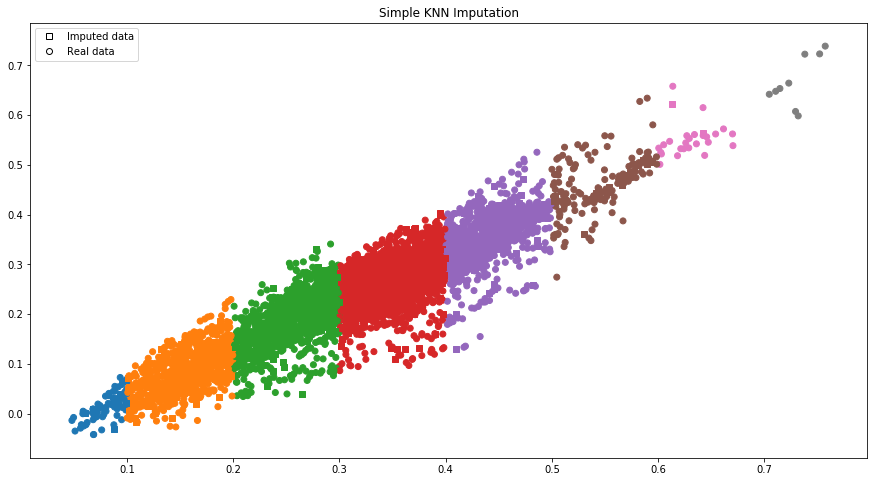

In [19]:
X_imp = X_train[['004412.438','004412.438_knn_imp','007498.059']]
plot_imputation_data(X_imp,'004412.438','004412.438_knn_imp','007498.059', 'Simple KNN Imputation')

In [20]:
print ('The variance of the column "004412.438" before imputation: {0:.3f} and after imputation: {1:.3f}'
       .format(X_train['004412.438'].var(),X_train['004412.438_knn_imp'].var()))

The variance of the column "004412.438" before imputation: 0.011 and after imputation: 0.011


<b> <i> The knn imputation creates no straight line, maintains the correlation between '004412.438_knn_imp' and '007498.059' with other features nor changes variance. </i> </b>

##### Model Driven Imputation: 
Imputation is done using the model, for example, a random forest regressor. Here, the dependent variable is the column that needs imputation and the remaining columns are independent variables.

In [21]:
feature_004412_438_missing = np.isnan(X_train["004412.438"])
train_cols = [col for col in features_columns if col !='004412.438']
rf_feature_004412_438 = RandomForestRegressor(n_estimators=100).fit(X_train[train_cols][~feature_004412_438_missing],
                                         X_train['004412.438'][~feature_004412_438_missing])
rf_predictions = rf_feature_004412_438.predict(X_train[train_cols][feature_004412_438_missing])
X_train.loc[feature_004412_438_missing, '004412.438_rf_imp']  = rf_predictions.ravel()
X_train.loc[~feature_004412_438_missing, '004412.438_rf_imp']  = X_train['004412.438'][~feature_004412_438_missing]

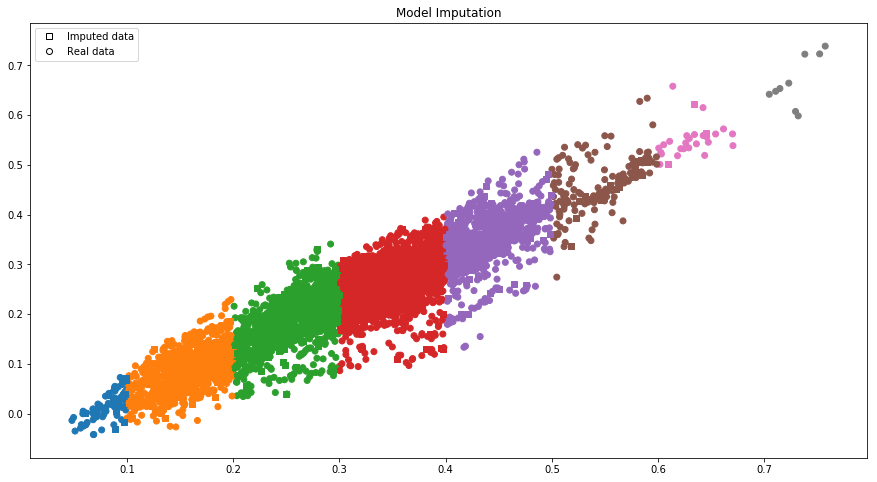

In [22]:
X_imp = X_train[['004412.438','004412.438_rf_imp','007498.059']]
plot_imputation_data(X_imp,'004412.438','004412.438_rf_imp','007498.059', 'Model Imputation')

In [23]:
print ('The variance of the column "004412.438" before imputation is : {0:.3f} and after imputation is : {1:.3f}'
       .format(X_train['004412.438'].var(),X_train['004412.438_rf_imp'].var()))

The variance of the column "004412.438" before imputation is : 0.011 and after imputation is : 0.011


<b><i> The model driven imputation creates no straight line, maintained the correlation between '004412.438_rf_imp' and '007498.059' with other features nor changes variance. </i> </b>

For the rest of the exercise, we continue using the imputation from KNN since it is easy to iterpret and imputation does not create bias with in the dataset.

In [24]:
X_train['004412.438'] = X_train['004412.438_knn_imp']
X_train = X_train.drop(axis=1, labels=['004412.438_imp', '004412.438_knn_imp', '004412.438_rf_imp'])

Lets apply KNN imputation on X_test dataset as well!

In [25]:
feature_004412_438_missing = np.isnan(X_test["004412.438"])
train_cols = [col for col in features_columns if col !='004412.438']
knn_feature_004412_438 = KNeighborsRegressor().fit(X_test[train_cols][~feature_004412_438_missing],
                                                   X_test['004412.438'][~feature_004412_438_missing])
knn_predictions = knn_feature_004412_438.predict(X_test[train_cols][feature_004412_438_missing])
X_test.loc[feature_004412_438_missing, '004412.438_knn_imp']  = knn_predictions.ravel()
X_test.loc[~feature_004412_438_missing, '004412.438_knn_imp']  = X_test['004412.438'][~feature_004412_438_missing]

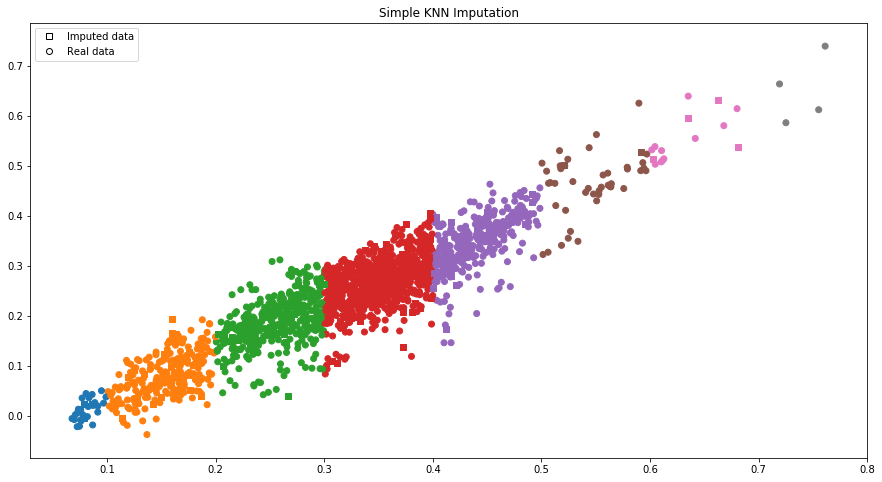

In [26]:
X_imp = X_test[['004412.438','004412.438_knn_imp','007498.059']]
plot_imputation_data(X_imp,'004412.438','004412.438_knn_imp','007498.059', 'Simple KNN Imputation')

In [27]:
print ('The variance of the column "004412.438" before imputation is: {0:.3f} and after imputation is {1:.3f} '
       .format(X_test['004412.438'].var(),X_test['004412.438_knn_imp'].var()))

The variance of the column "004412.438" before imputation is: 0.011 and after imputation is 0.011 


In [28]:
X_test['004412.438'] = X_test['004412.438_knn_imp']
X_test = X_test.drop(axis=1, labels=['004412.438_knn_imp'])

<b><i>The knn imputation has creates no straight line, maintains the correlation between '004412.438_knn_imp' and '007498.059' with other features nor changes variance. </i></b>

#### Engineer features and targets

Normalization is used to make the features consistent with each other, which allow us to evaluate output of the future models better.

Normalization 
- Makes training data less sensitive to the scale of features so, we can better solve for coefficients.
- improves analysis from multiple models.
- Ensures that the convergence problem does not have large variance, making optimization feasible.

Generally, target features are not scaled/normalized.

##### Correlation betweem features

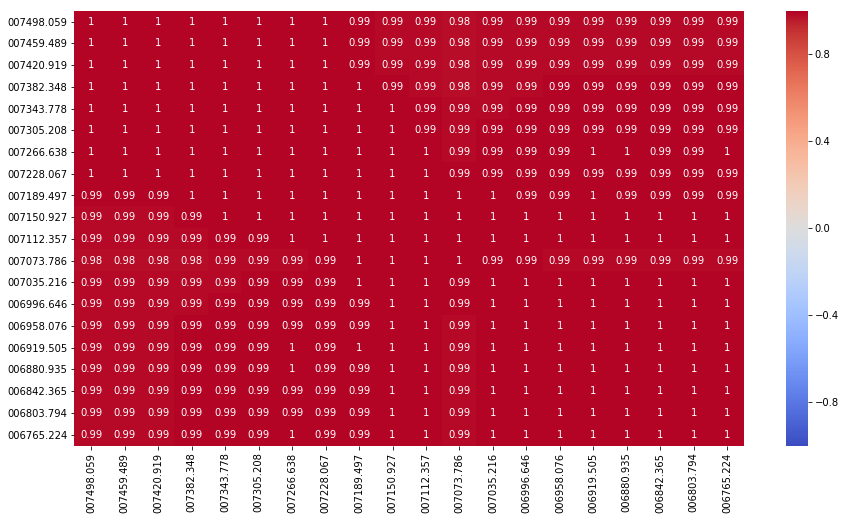

In [29]:
X_train_scaled = scale(X_train)

# considered 20 features
plt.figure(figsize=(15, 8))
sns.heatmap(pd.DataFrame(data=X_train_scaled, columns=features_columns)[features_columns[0:20]].corr(), 
            vmin=-1, 
            cmap='coolwarm', 
            annot=True)

<b><i> The feature columns are highly correlated with each other. The high correlation among the features makes the model unstable </i></b>

##### Feature Distribution

In [30]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(30,30))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='red')
    fig.tight_layout()
    plt.show()

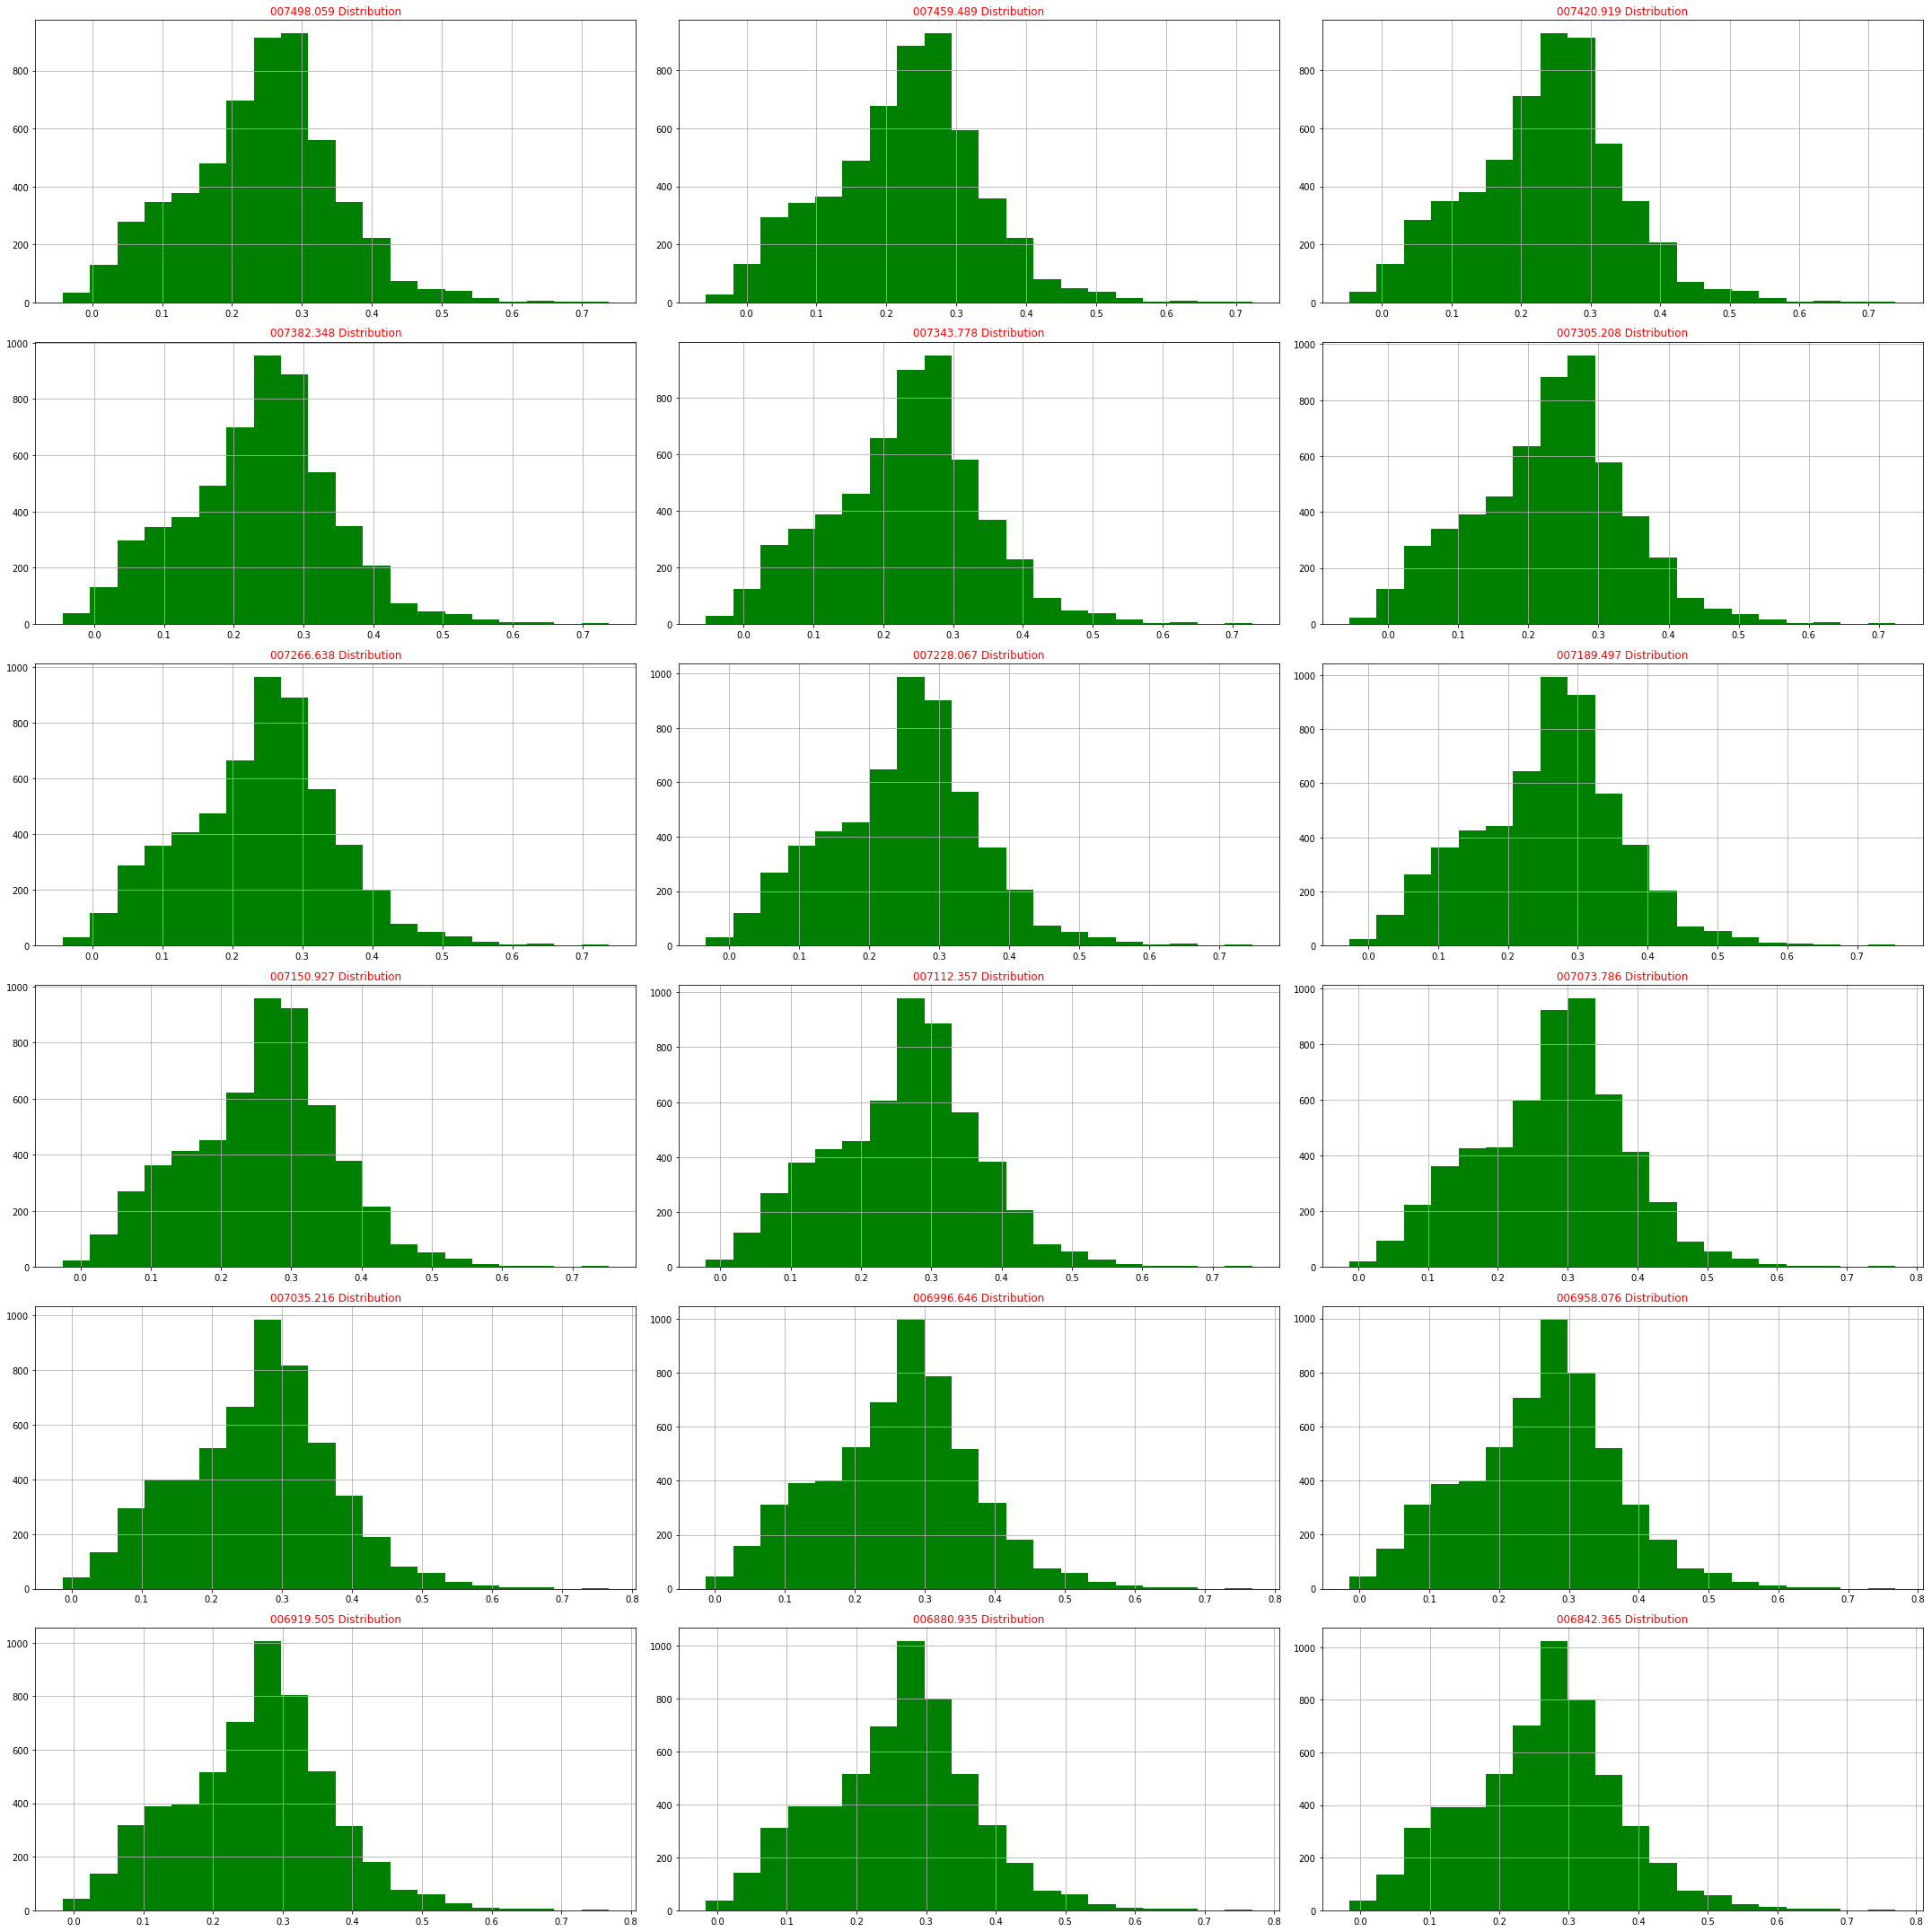

In [31]:
histograms_plot(X_train,features_columns[0:18],6,3)

Looking at the distribution of example features, the feature scaling seems to be consistent with each other so, we dont apply any normalization here. We can scale the datasets accordinlgy based on the model selection. 

For example,

- Regression, Logistic Regression: are insensitive to standardization but improves the numerical stability of model (X determines the update rate in gradient decent formual. Therefore, a larger X will lead to a greater leap in the gradient landscape but we need baby steps to find the global optima), speeds up the traning process, and scaling gives equal importance to each feature.
- Distance-based algorithms - Distance-based algorithms such as K-MEANS and KNN are more likely dependant on standardization as the algorithm needs to calculate distance between entries and scaling features changes the distance between nodes.
- Tree-based decision algorithms are resilent to feature scaling.

Lets have look at target feature distribution.

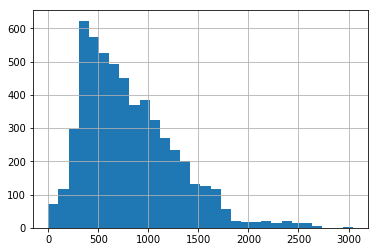

In [32]:
y_train.hist(bins=30)

The distribution is right skewed.

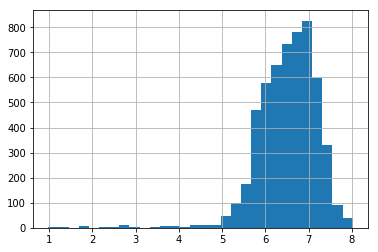

In [33]:
y_train_log = np.log1p(y_train)
y_train_log.hist(bins=30)

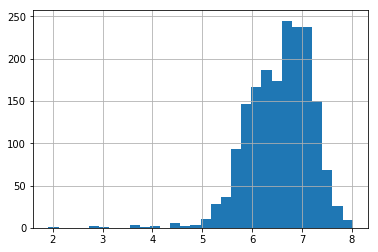

In [34]:
y_test_log = np.log1p(y_test)
y_test_log.hist(bins=30)

Label scaling is not important, the algorithm should be able learn based on features and reduce the error irrespective of label scaling.

#### Train, Test split

We already completed the train, test split. Here, we just do normal data level checks.

In [35]:
print('The columns with missing values in features_targets dataframe: {}'
      .format(list(X_train.columns[X_train.isna().any()])))

The columns with missing values in features_targets dataframe: []


In [36]:
print('The columns with missing values in features_targets dataframe: {}'
      .format(list(X_test.columns[X_test.isna().any()])))

The columns with missing values in features_targets dataframe: []


In [37]:
y_train[y_train.isna()]

Series([], Name: M3 Al, dtype: float64)

In [38]:
y_test[y_test.isna()]

Series([], Name: M3 Al, dtype: float64)

In [39]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((5509, 179), (1837, 179), (5509,), (1837,))

#### 2.Regression Model

Scaling the training and test features to improve the performance and also brings the feature scale further close to each other.

In [40]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### OLS Regression

In [41]:
lr = LinearRegression()
lr_model = lr.fit(X_train_scaled, y_train)
print('The performance of OLS regression on the training dataset is {:.3f}'
      .format(lr_model.score(X_train_scaled, y_train)))

The performance of OLS regression on the training dataset is 0.930


The performance of the linear regression is quite good but it may be possible that the model is overfitting on the dataset, lets do the linear regression with cross validtion so the model scores can be evaluated on different train and validation dataset.

In [42]:
lr_cv = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print('The mean performance of OLS regression on the training dataset is {:.3f}'.format(np.mean(lr_cv)))

The mean performance of OLS regression on the training dataset is 0.924


The average performance of the linear regression with 10-fold cross validation is still quite good but linear regrssion model cannot be controlled so, the model may be very simple or complex. 

In [43]:
print('The best performance of ridge regression on the test dataset is {:.3f}'
      .format(lr_model.score(X_test_scaled, y_test)))

The best performance of ridge regression on the test dataset is 0.911


The performance of linear regression on test dataset is quite good as well.

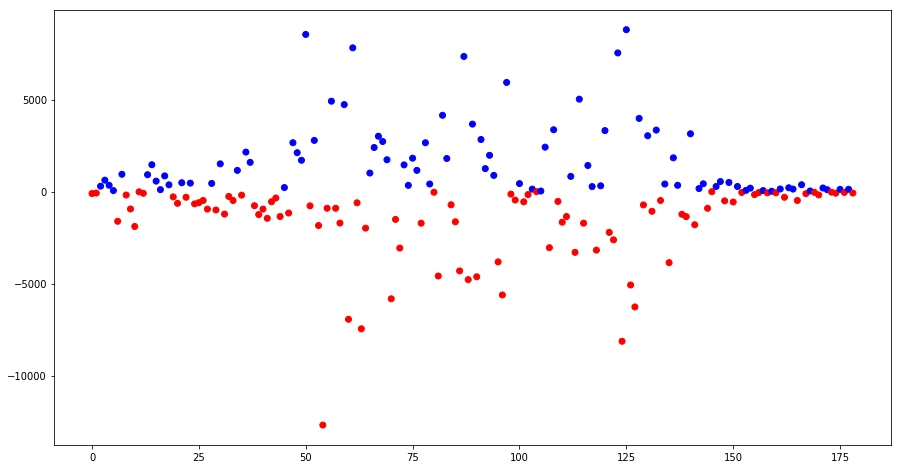

In [44]:
plt.figure(figsize=(15, 8))
plt.scatter(range(X_train_scaled.shape[1]), lr.coef_, c=np.sign(lr.coef_), cmap='bwr_r')

Observing the coefficients of lr model, the model is dominated by certain features. As we noticed previously, the features are highly correlated so, the dominant features might not be same always. Therefore, the model wont be stable.

##### Ridge

Ridge uses l2 regularization to control the model and tries too keep the coefficients of as close as possible to zeros.

In [45]:
ridge = Ridge()
param_grid = {'alpha':np.logspace(-5,4,10)}
grid_ridge = GridSearchCV(ridge, param_grid, cv=10, return_train_score=True)
grid_ridge.fit(X_train_scaled, y_train)
print('The best performance of ridge regression on the training dataset is {:.3f}'.format(grid_ridge.best_score_))
print('The following is the best param of ridge model {}'.format(grid_ridge.best_params_))

The best performance of ridge regression on the training dataset is 0.924
The following is the best param of ridge model {'alpha': 0.001}


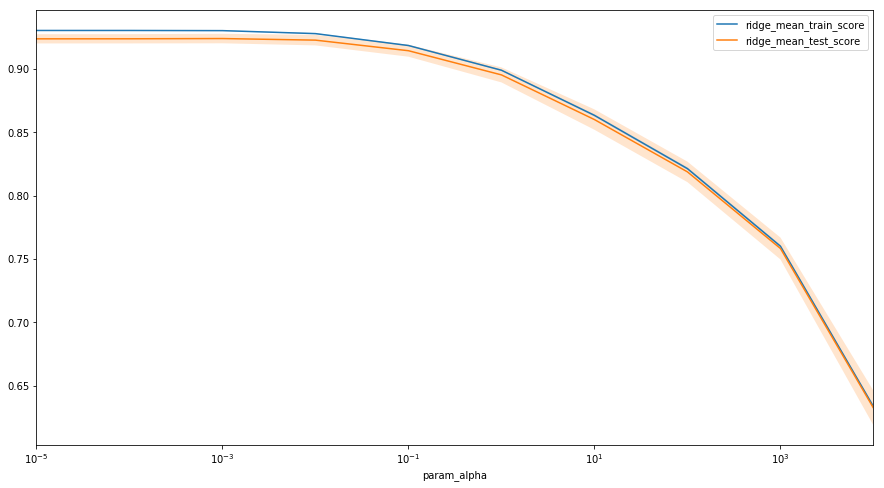

In [46]:
results_ridge = pd.DataFrame(grid_ridge.cv_results_)
ax = results_ridge.plot('param_alpha', 'mean_train_score', label='ridge_mean_train_score', figsize=(15,8))
results_ridge.plot('param_alpha', 'mean_test_score', ax=ax, label='ridge_mean_test_score')
ax.fill_between(results_ridge.param_alpha.astype(np.float),
                 results_ridge['mean_train_score'] + results_ridge['std_train_score'],
                 results_ridge['mean_train_score'] - results_ridge['std_train_score'], alpha=0.2)
ax.fill_between(results_ridge.param_alpha.astype(np.float),
                 results_ridge['mean_test_score'] + results_ridge['std_test_score'],
                 results_ridge['mean_test_score'] - results_ridge['std_test_score'], alpha=0.2)
plt.legend(loc='best')
plt.xscale("log")

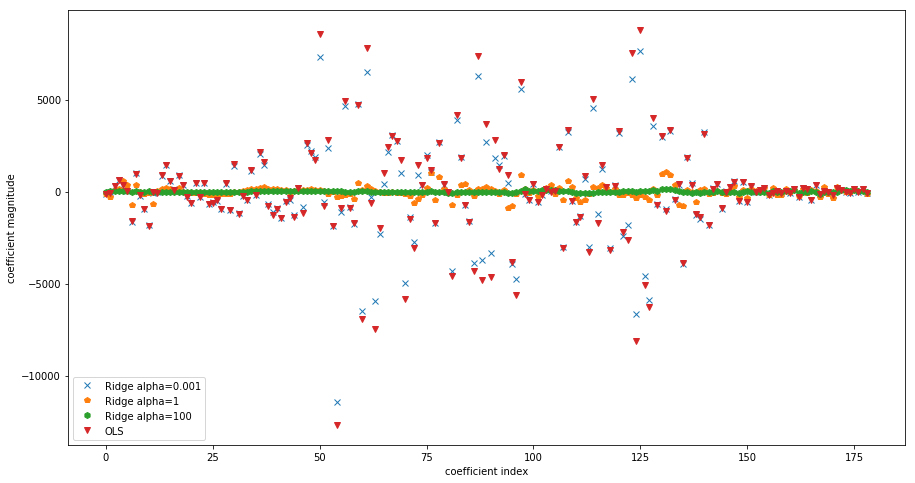

In [47]:
ridge = grid_ridge.best_estimator_
ridge100 = Ridge(alpha=100).fit(X_train_scaled, y_train)
ridge1 = Ridge(alpha=1).fit(X_train_scaled, y_train)
plt.figure(figsize=(15, 8))
plt.plot(ridge.coef_, 'x', label='Ridge alpha=0.001')
plt.plot(ridge1.coef_, 'p', label='Ridge alpha=1')
plt.plot(ridge100.coef_, 'h', label='Ridge alpha=100')
plt.plot(lr.coef_, 'v', label='OLS')
plt.xlabel("coefficient index")
plt.ylabel("coefficient magnitude")
plt.legend(loc='lower left')

In [48]:
print('The best performance of ridge regression on the test dataset is {:.3f}'
      .format(grid_ridge.best_estimator_.score(X_test_scaled, y_test)))

The best performance of ridge regression on the test dataset is 0.911


The ridge model is behaving very similar to linear regression. The alpha is very low as well. We can also notice the coefficients of features are very close to the ones from linear regression. Low alpha suggest that model is complex and might be overfitting on the dataset. Yet, model is performing good both on train and test dataset.

##### Random Forest Regression

Before trying lasso (it is taking ages to converge). Lets try random forest regression since this algorithm tries to fix both bias and variance issue by building multiple decision trees with randomly bootstrapping data from provided examples and randomly selecting the sample features to split/to grow trees. 

We will use X_train dataset since decision trees are resilent to feature scaling

In [49]:
# run time 12+ mins
rf = RandomForestRegressor(random_state = 42)
param_grid = {'bootstrap': [True],
              'min_samples_leaf': [4, 8],
              'min_samples_split': [8, 16],
              'n_estimators': [100, 150, 200]
             }
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, return_train_score=True)
grid_rf.fit(X_train, y_train)
print('The best performance of random forest regression on the training dataset is {:.3f}'.format(grid_rf.best_score_))
print('The following is the best param of ridge model {}'.format(grid_rf.best_params_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 11.5min finished


The best performance of random forest regression on the training dataset is 0.881
The following is the best param of ridge model {'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}


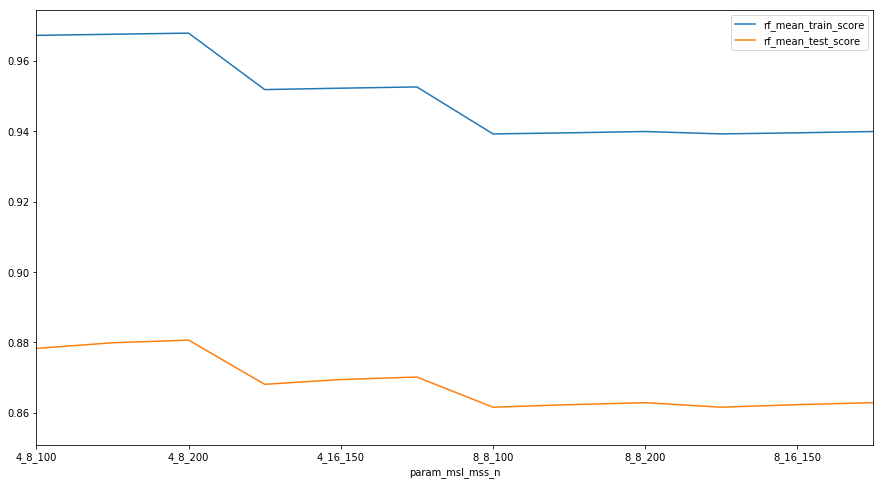

In [50]:
results_rf = pd.DataFrame(grid_rf.cv_results_)
results_rf['param_msl_mss_n'] = results_rf['param_min_samples_leaf'].astype(str) \
                                + '_' + results_rf['param_min_samples_split'].astype(str)\
                                + '_' + results_rf['param_n_estimators'].astype(str)
ax = results_rf.plot('param_msl_mss_n', 'mean_train_score', label='rf_mean_train_score', figsize=(15,8))
results_rf.plot('param_msl_mss_n', 'mean_test_score', ax=ax, label='rf_mean_test_score')
ax.fill_between(results_rf.param_msl_mss_n.astype(np.float),
                 results_rf['mean_train_score'] + results_rf['std_train_score'],
                 results_rf['mean_train_score'] - results_rf['std_train_score'], alpha=0.2)
ax.fill_between(results_rf.param_msl_mss_n.astype(np.float),
                 results_rf['mean_test_score'] + results_rf['std_test_score'],
                 results_rf['mean_test_score'] - results_rf['std_test_score'], alpha=0.2)
plt.legend(loc='best')

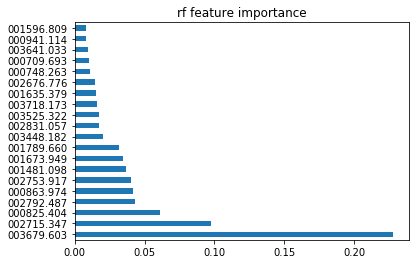

In [51]:
feat_importances = pd.Series(grid_rf.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', title='rf feature importance')

In [52]:
print('The best performance of random forest regressor on the test dataset is {:.3f}'
      .format(grid_rf.best_estimator_.score(X_test, y_test)))

The best performance of random forest regressor on the test dataset is 0.908


We can notice that random forest performance is low comparatively to linear regression and ridge but the performance on test set is very similar compare to linear and ridge regression. Since the random forest build multiple decision trees each time with different dataset and averages the performances, the average performance on train dataset is low but performd very well on test datatset.

###### Feature selection

The twenty most important features as per the random regression is plotted in the figure. Lets retrain the random forest again with top 10 important features but with larger space for hyper parameters to search.

In [53]:
imp_features = feat_importances.nlargest(10).index.to_list()

In [54]:
# run time 14 mins
start_time = time.time()
rf_imp = RandomForestRegressor(random_state = 42)
param_grid_imp = {'bootstrap': [True],
              'min_samples_leaf': [2, 4, 8, 16],
              'min_samples_split': [2, 4, 8, 16, 32],
              'n_estimators': [100, 150, 200, 300, 400]
             }
grid_rf_imp = GridSearchCV(estimator=rf_imp, param_grid=param_grid_imp, cv=3, n_jobs=-1, verbose=2, 
                           return_train_score=True)
grid_rf_imp.fit(X_train[imp_features], y_train)
print('The best performance of random forest regression on the training dataset is {:.3f}'.format(grid_rf_imp.best_score_))
print('The following is the best param of ridge model {}'.format(grid_rf_imp.best_params_))
print("--- %s seconds run time ---" % (time.time() - start_time))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.3min finished


The best performance of random forest regression on the training dataset is 0.857
The following is the best param of ridge model {'bootstrap': True, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
--- 505.7812292575836 seconds run time ---


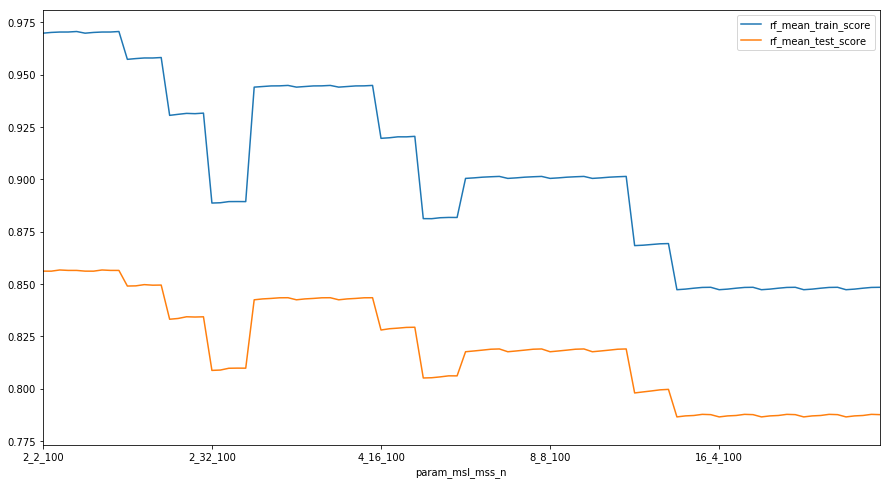

In [55]:
results_rf_imp = pd.DataFrame(grid_rf_imp.cv_results_)
results_rf_imp['param_msl_mss_n'] = results_rf_imp['param_min_samples_leaf'].astype(str) \
                                + '_' + results_rf_imp['param_min_samples_split'].astype(str)\
                                + '_' + results_rf_imp['param_n_estimators'].astype(str)
ax = results_rf_imp.plot('param_msl_mss_n', 'mean_train_score', label='rf_mean_train_score', figsize=(15,8))
results_rf_imp.plot('param_msl_mss_n', 'mean_test_score', ax=ax, label='rf_mean_test_score')
ax.fill_between(results_rf_imp.param_msl_mss_n.astype(np.float),
                 results_rf_imp['mean_train_score'] + results_rf_imp['std_train_score'],
                 results_rf_imp['mean_train_score'] - results_rf_imp['std_train_score'], alpha=0.2)
ax.fill_between(results_rf_imp.param_msl_mss_n.astype(np.float),
                 results_rf_imp['mean_test_score'] + results_rf_imp['std_test_score'],
                 results_rf_imp['mean_test_score'] - results_rf_imp['std_test_score'], alpha=0.2)
plt.legend(loc='best')

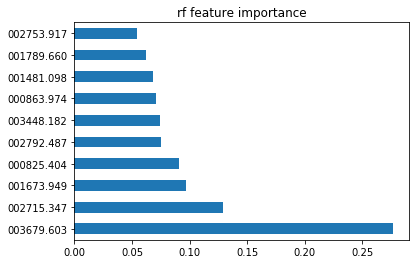

In [56]:
feat_importances_imp = pd.Series(grid_rf_imp.best_estimator_.feature_importances_, index=X_train[imp_features].columns)
feat_importances_imp.nlargest(20).plot(kind='barh', title='rf feature importance')

In [57]:
print('The best performance of random forest regressor on the test dataset is {:.3f}'
      .format(grid_rf_imp.best_estimator_.score(X_test[imp_features], y_test)))

The best performance of random forest regressor on the test dataset is 0.886


With just 10 features, the score is very close to the score, which we got considering all the features but training only with limited features reduces the training time and enable us to explore further options in grid search.

##### Lasso

Considering all the features, lasso is not converging, and takes time when we increase max itereations. Now, we know the important features based on random regressor, lets try the lasso with only certain important feaures.

In [58]:
imp_features = feat_importances.nlargest(100).index.to_list()
X_train_selected_columns = X_train[imp_features]
X_test_selected_columns = X_test[imp_features]

In [59]:
scaler = StandardScaler()
scaler.fit(X_train_selected_columns)
X_train_selected_columns_scaled = scaler.transform(X_train_selected_columns)
X_test_selected_columns_scaled = scaler.transform(X_test_selected_columns)

In [60]:
# run time 10 mins
lasso = Lasso(max_iter=10000)
param_grid = {'alpha':np.logspace(-5,4,10)}
grid_lasso = GridSearchCV(lasso, param_grid, cv=10, return_train_score=True)
grid_lasso.fit(X_train_selected_columns_scaled, y_train)
print('The best performance of lasso regression on the training dataset is {:.3f}'.format(grid_lasso.best_score_))
print('The following is the best param of lasso model {}'.format(grid_lasso.best_params_))

The best performance of lasso regression on the training dataset is 0.881
The following is the best param of lasso model {'alpha': 1e-05}


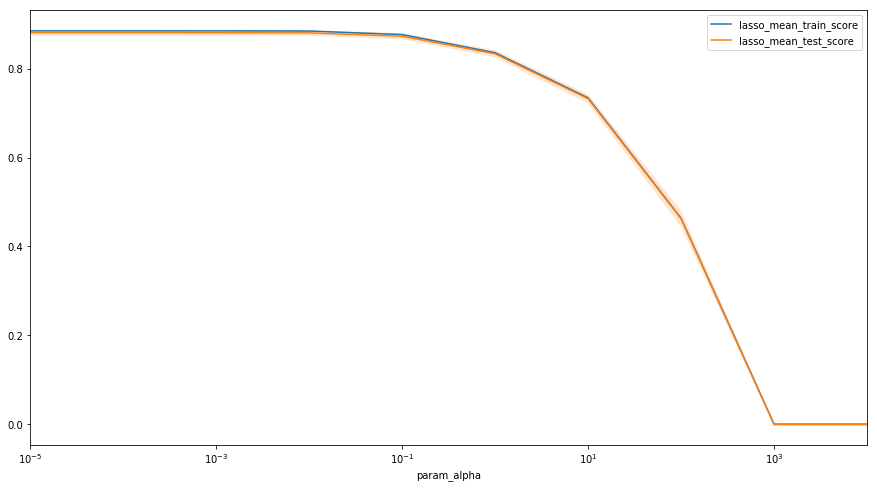

In [61]:
results_lasso = pd.DataFrame(grid_lasso.cv_results_)
ax = results_lasso.plot('param_alpha', 'mean_train_score', label='lasso_mean_train_score', figsize=(15,8))
results_lasso.plot('param_alpha', 'mean_test_score', ax=ax, label='lasso_mean_test_score')
ax.fill_between(results_lasso.param_alpha.astype(np.float),
                 results_lasso['mean_train_score'] + results_lasso['std_train_score'],
                 results_lasso['mean_train_score'] - results_lasso['std_train_score'], alpha=0.2)
ax.fill_between(results_lasso.param_alpha.astype(np.float),
                 results_lasso['mean_test_score'] + results_lasso['std_test_score'],
                 results_lasso['mean_test_score'] - results_lasso['std_test_score'], alpha=0.2)
plt.legend(loc='best')
plt.xscale("log")

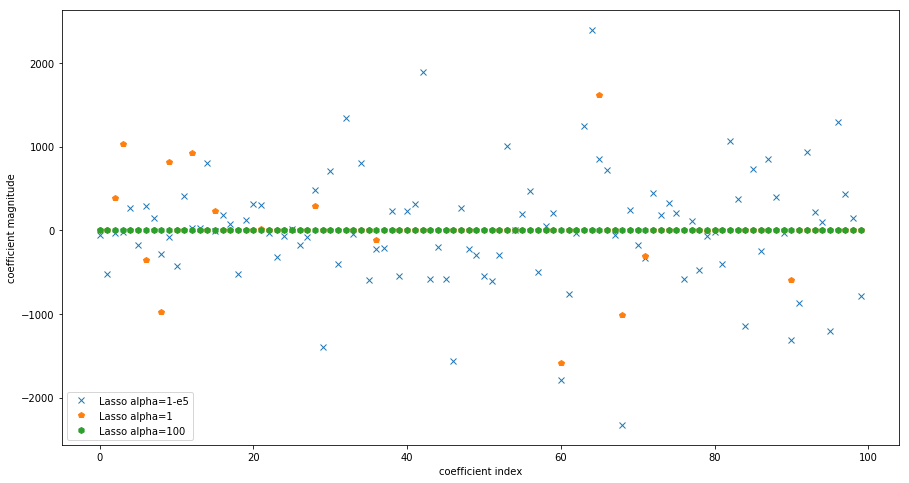

In [62]:
lasso = grid_lasso.best_estimator_
lasso100 = Lasso(alpha=100).fit(X_train_selected_columns, y_train)
lasso1 = Lasso(alpha=1).fit(X_train_selected_columns, y_train)
plt.figure(figsize=(15, 8))
plt.plot(lasso.coef_, 'x', label='Lasso alpha=1-e5')
plt.plot(lasso1.coef_, 'p', label='Lasso alpha=1')
plt.plot(lasso100.coef_, 'h', label='Lasso alpha=100')
plt.xlabel("coefficient index")
plt.ylabel("coefficient magnitude")
plt.legend(loc='lower left')

In [63]:
print('The best performance of lasso regression on the test dataset is {:.3f}'
      .format(grid_lasso.best_estimator_.score(X_test_selected_columns_scaled, y_test)))

The best performance of lasso regression on the test dataset is 0.879


The accruacy with only important features is still better but the alpha is very low so, lasso might also be overfitting on the dataset. Yet, the performance on test dataset is still quite good.

##### Regression results

###### Challenges

- High correlation between features.
- Lasso: Training takes alot of time, convergence issues, works fine with limited features (important).
- Random Forest Regressor - Training takes more time with all the features.

###### Conclusion

- Linear Regression and Ridge are  performing better, the alpha in ridge is very small it means that the model is complex and might be overfitting.
- Randomg Forest Regression takes care of both bias and variance problems by running multiple decision trees with random dataset and features for splitting the decision tress.And, the performance of Random Forest Regressor is very to close to the Ridge and Logistic Regression.
- Implemented feature selection mechanism to speed up the traning for Lasso and Random Forest Regressor using feature importance from Random Forest Regressor.
- With important features, lasso performance is comparable with Random Forest and Ridge but again alpha is very low leading to complex model and overfit.

###### Scores on test dataset

- Logistic Regression - 0.911
- Ridge - 0.911
- Random Forest Regressor - 0.908
- Random Forest Regressor (with feature selection) - 0.886 
- Lasso (with feature selection) - 0.879

I would chose random forest regressor as it takes care of both bias and variance issues but should be careful with new data points because random forest does not work on data points which has not seen before.

#### 3.Classification Model

In [64]:
X = features_targets[features_columns]
y = features_targets[['M3 Al']] # considered M3 A1 as target column as it is fillied for every row.

##### New Target variable

In [65]:
y_cat = pd.qcut(y['M3 Al'], [0, .33, .67, 1.] , labels=["HIGH", "MEDIUM", "LOW"])

In [66]:
y_cat.value_counts()

MEDIUM    2497
HIGH      2425
LOW       2424
Name: M3 Al, dtype: int64

The target/label distribution is balanced in the dataset.

In [67]:
le = preprocessing.LabelEncoder()
y_label = le.fit(y_cat).transform(y_cat)

In [68]:
pd.Series(y_label).value_counts()

2    2497
0    2425
1    2424
dtype: int64

##### Test, Train Split and Impute

In [69]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.25, random_state=42)

# train features imputation
feature_004412_438_missing = np.isnan(X_train["004412.438"])
train_cols = [col for col in features_columns if col !='004412.438']
knn_feature_004412_438 = KNeighborsRegressor().fit(X_train[train_cols][~feature_004412_438_missing],
                                                   X_train['004412.438'][~feature_004412_438_missing])
knn_predictions = knn_feature_004412_438.predict(X_train[train_cols][feature_004412_438_missing])
X_train.loc[feature_004412_438_missing, '004412.438_knn_imp']  = knn_predictions.ravel()
X_train.loc[~feature_004412_438_missing, '004412.438_knn_imp']  = X_train['004412.438'][~feature_004412_438_missing]
X_train['004412.438'] = X_train['004412.438_knn_imp']
X_train = X_train.drop(axis=1, labels=['004412.438_knn_imp'])

# test features imputation
feature_004412_438_missing = np.isnan(X_test["004412.438"])
train_cols = [col for col in features_columns if col !='004412.438']
knn_feature_004412_438 = KNeighborsRegressor().fit(X_test[train_cols][~feature_004412_438_missing],
                                                   X_test['004412.438'][~feature_004412_438_missing])
knn_predictions = knn_feature_004412_438.predict(X_test[train_cols][feature_004412_438_missing])
X_test.loc[feature_004412_438_missing, '004412.438_knn_imp']  = knn_predictions.ravel()
X_test.loc[~feature_004412_438_missing, '004412.438_knn_imp']  = X_test['004412.438'][~feature_004412_438_missing]
X_test['004412.438'] = X_test['004412.438_knn_imp']
X_test = X_test.drop(axis=1, labels=['004412.438_knn_imp'])

##### Scaling

In [70]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [71]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((5509, 179), (1837, 179), (5509,), (1837,))

##### Linear SVM

In [72]:
def grid_search_cv(X, y):
    tuned_parameters = {"C":[0.01, 0.1, 1, 10, 100]}
    clf = LinearSVC(verbose=0, max_iter=1000)
    svc_cv = GridSearchCV(clf, tuned_parameters, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))
    svc_cv.fit(X,y)
    return svc_cv.best_params_, svc_cv.best_score_, svc_cv.best_estimator_

In [73]:
start_time = time.time()
best_params, best_score, best_model = grid_search_cv(X_train_scaled, y_train)
print("--- %s seconds run time ---" % (time.time() - start_time))

--- 124.29738116264343 seconds run time ---


In [74]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best n_neighbors: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_scaled, y_test)))

best mean cross-validation score: 0.865
best n_neighbors: {'C': 1}
test-set score: 0.870


In [75]:
y_pred = best_model.predict(X_test_scaled)
count_misclassified = (y_test != y_pred).sum()
print('misclassified datapoints: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('accuracy: {:.3f}'.format(accuracy))

misclassified datapoints: 239
accuracy: 0.870


In [76]:
confusion_matrix(y_test,y_pred)

array([[519,   2,  69],
       [  0, 568,  66],
       [ 42,  60, 511]])

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       590
           1       0.90      0.90      0.90       634
           2       0.79      0.83      0.81       613

    accuracy                           0.87      1837
   macro avg       0.87      0.87      0.87      1837
weighted avg       0.87      0.87      0.87      1837



The linearSVC is performing quite good on both test and train dataset. 

##### Logistic Multinominal

In [78]:
def grid_search_cv(X, y):
    tuned_parameters = {"C":np.logspace(-6, 3, 10)}
    clf = LogisticRegression(multi_class='multinomial',
                             solver='lbfgs', 
                             random_state=42, 
                             max_iter=1000)
    logreg_cv = GridSearchCV(clf,
                             tuned_parameters, 
                             cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True))
    logreg_cv.fit(X,y)
    return logreg_cv.best_params_, logreg_cv.best_score_, logreg_cv.best_estimator_

In [79]:
start_time = time.time()
best_params, best_score, best_model = grid_search_cv(X_train_scaled, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 112.34204602241516 seconds ---


In [80]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best n_neighbors: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_scaled, y_test)))

best mean cross-validation score: 0.886
best n_neighbors: {'C': 100.0}
test-set score: 0.892


In [81]:
y_pred = best_model.predict(X_test_scaled)
count_misclassified = (y_test != y_pred).sum()
print('misclassified datapoints: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('accuracy: {:.3f}'.format(accuracy))

misclassified datapoints: 198
accuracy: 0.892


In [82]:
confusion_matrix(y_test,y_pred)

array([[535,   2,  53],
       [  0, 579,  55],
       [ 43,  45, 525]])

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       590
           1       0.92      0.91      0.92       634
           2       0.83      0.86      0.84       613

    accuracy                           0.89      1837
   macro avg       0.89      0.89      0.89      1837
weighted avg       0.89      0.89      0.89      1837



The logistic regression performance is quite comparable to LinearSVC and actually better but the regularization parameter C is bit high. Therefore, implies low regularization, complex model and overfit.

##### Random Forest Classifier

We will use X_train dataset since decision trees are resilent to feature scaling

In [84]:
def grid_search_cv(X, y):
    param_grid = {'bootstrap': [True],
                  'min_samples_leaf': [2, 4, 8],
                  'min_samples_split': [2, 4, 8, 16],
                  'n_estimators': [100, 150, 200, 300]}
    clf = RandomForestClassifier(random_state = 42)
    rf_cv = GridSearchCV(estimator = clf, param_grid = param_grid,
                         cv=3, n_jobs=-1, verbose=2, 
                         return_train_score=True)
    rf_cv.fit(X,y)
    return rf_cv.best_params_, rf_cv.best_score_, rf_cv.best_estimator_, rf_cv.cv_results_

In [85]:
start_time = time.time()
best_params, best_score, best_model, cv_results = grid_search_cv(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.8min finished


--- 303.9214026927948 seconds ---


In [86]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best n_neighbors: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test, y_test)))

best mean cross-validation score: 0.889
best n_neighbors: {'bootstrap': True, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
test-set score: 0.904


In [87]:
y_pred = best_model.predict(X_test)
count_misclassified = (y_test != y_pred).sum()
print('misclassified datapoints: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('accuracy: {:.3f}'.format(accuracy))

misclassified datapoints: 176
accuracy: 0.904


In [88]:
confusion_matrix(y_test,y_pred)

array([[548,   0,  42],
       [  1, 580,  53],
       [ 28,  52, 533]])

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       590
           1       0.92      0.91      0.92       634
           2       0.85      0.87      0.86       613

    accuracy                           0.90      1837
   macro avg       0.91      0.90      0.90      1837
weighted avg       0.90      0.90      0.90      1837



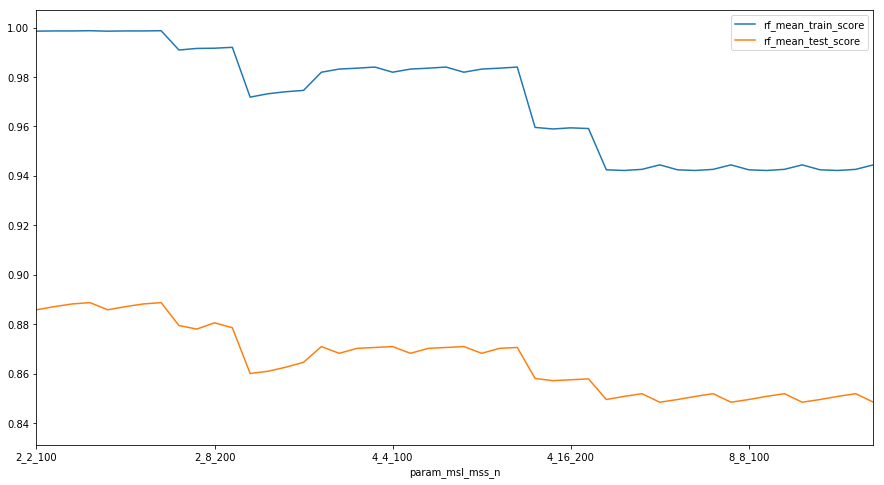

In [90]:
results_rf = pd.DataFrame(cv_results)
results_rf['param_msl_mss_n'] = results_rf['param_min_samples_leaf'].astype(str) \
                                + '_' + results_rf['param_min_samples_split'].astype(str)\
                                + '_' + results_rf['param_n_estimators'].astype(str)
ax = results_rf.plot('param_msl_mss_n', 'mean_train_score', label='rf_mean_train_score', figsize=(15,8))
results_rf.plot('param_msl_mss_n', 'mean_test_score', ax=ax, label='rf_mean_test_score')
ax.fill_between(results_rf.param_msl_mss_n.astype(np.float),
                 results_rf['mean_train_score'] + results_rf['std_train_score'],
                 results_rf['mean_train_score'] - results_rf['std_train_score'], alpha=0.2)
ax.fill_between(results_rf.param_msl_mss_n.astype(np.float),
                 results_rf['mean_test_score'] + results_rf['std_test_score'],
                 results_rf['mean_test_score'] - results_rf['std_test_score'], alpha=0.2)
plt.legend(loc='best')

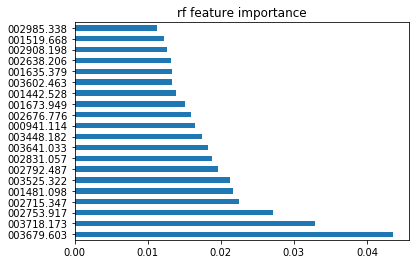

In [91]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', title='rf feature importance')

The random forest classifier performance better than LinearSVC and Logistic Regression.

##### Feature Engineering


The available features are already highly correlated, I would not feel comfortable to add interactions. Yet, further EDA can be done to identify the relation between features and labels, and aim for binning or categorizing numerical variables. To proceed with that I would further like to understand what each feature in dataset represents, I get that they are infrared readings and could not find the exact meaning of each feature. 

##### Feature selection

Lets do feature selection based on random forest classifier.

In [92]:
select_model = SelectFromModel(RandomForestClassifier(n_estimators = 100))
select_model.fit(X_train, y_train)
selected_feat= X_train.columns[(select_model.get_support())]

In [93]:
selected_feat

Index(['005260.984', '005222.414', '005183.843', '005068.133', '003718.173',
       '003679.603', '003641.033', '003602.463', '003563.892', '003525.322',
       '003486.752', '003448.182', '003409.611', '003371.041', '003332.471',
       '003293.900', '003255.330', '003139.619', '003101.049', '003062.479',
       '003023.909', '002985.338', '002946.768', '002908.198', '002869.628',
       '002831.057', '002792.487', '002753.917', '002715.347', '002676.776',
       '002638.206', '002599.636', '002561.065', '002522.495', '002483.925',
       '002021.082', '001905.371', '001789.660', '001712.520', '001673.949',
       '001635.379', '001596.809', '001519.668', '001481.098', '001442.528',
       '001403.958', '001365.387', '001326.817', '001288.247', '001249.677',
       '001172.536', '001133.966', '001095.395', '001018.255', '000979.685',
       '000941.114', '000902.544', '000863.974', '000825.404', '000748.263',
       '000709.693', '000671.123', '000632.552'],
      dtype='object')

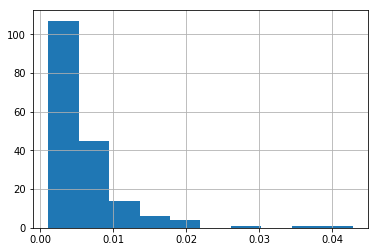

In [94]:
pd.Series(select_model.estimator_.feature_importances_.ravel()).hist()

Lets run the random forest with selected features and see how much the model can learn and perform on test dataset.

In [95]:
# using the last definition of grid_search_cv
start_time = time.time()
best_params, best_score, best_model, cv_results = grid_search_cv(X_train[selected_feat], y_train)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 14.5min finished


--- 875.7067079544067 seconds ---


In [96]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best n_neighbors: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test[selected_feat], y_test)))

best mean cross-validation score: 0.885
best n_neighbors: {'bootstrap': True, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
test-set score: 0.907


In [97]:
y_pred = best_model.predict(X_test[selected_feat])
count_misclassified = (y_test != y_pred).sum()
print('misclassified datapoints: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('accuracy: {:.3f}'.format(accuracy))

misclassified datapoints: 170
accuracy: 0.907


In [98]:
confusion_matrix(y_test,y_pred)

array([[548,   1,  41],
       [  0, 578,  56],
       [ 29,  43, 541]])

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       590
           1       0.93      0.91      0.92       634
           2       0.85      0.88      0.86       613

    accuracy                           0.91      1837
   macro avg       0.91      0.91      0.91      1837
weighted avg       0.91      0.91      0.91      1837



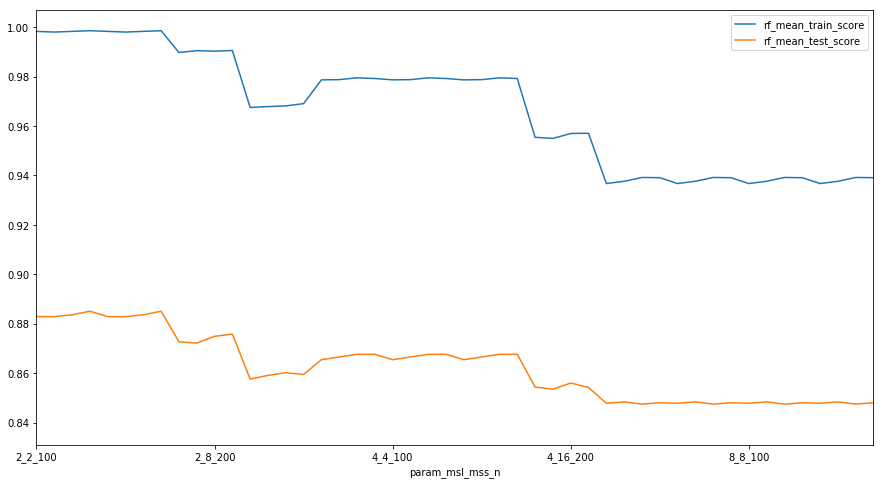

In [100]:
results_rf = pd.DataFrame(cv_results)
results_rf['param_msl_mss_n'] = results_rf['param_min_samples_leaf'].astype(str) \
                                + '_' + results_rf['param_min_samples_split'].astype(str)\
                                + '_' + results_rf['param_n_estimators'].astype(str)
ax = results_rf.plot('param_msl_mss_n', 'mean_train_score', label='rf_mean_train_score', figsize=(15,8))
results_rf.plot('param_msl_mss_n', 'mean_test_score', ax=ax, label='rf_mean_test_score')
ax.fill_between(results_rf.param_msl_mss_n.astype(np.float),
                 results_rf['mean_train_score'] + results_rf['std_train_score'],
                 results_rf['mean_train_score'] - results_rf['std_train_score'], alpha=0.2)
ax.fill_between(results_rf.param_msl_mss_n.astype(np.float),
                 results_rf['mean_test_score'] + results_rf['std_test_score'],
                 results_rf['mean_test_score'] - results_rf['std_test_score'], alpha=0.2)
plt.legend(loc='best')

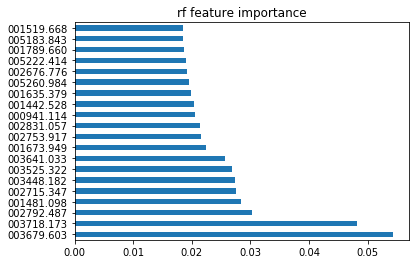

In [101]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train[selected_feat].columns)
feat_importances.nlargest(20).plot(kind='barh', title='rf feature importance')

The performance is better compare to the random forest with all features.

##### Classification Results

###### Challenges

- No further chanllenges with dataset except that features are highly correlated.
- SVC assumes that datapoints are linearly seperable.

###### Conclusion

- Random Forest Classifier performs better than Logistic and SVC models.
- Random Forest Classifier(RFC) performs with selected features performs better than RFC considering all features.

######  Scores on test dataset

- Logistic: 0.892
- LinearSVC: 0.867
- Random Forest Clasifier: 0.904
- Random Forest Clasifier (selected features): 0.907

I would chose random forest classifier as it takes care of both bias and variance problems. Moreover, random forest classifier are highly accurate, generalize better, and interpretable. 